# Analisi Diffusione COVID-19 
Il committente richiede di avere un report su casi e vaccinazioni in diverse aree del mondo; a tal fine, richiede di utilizzare il dataset, curato da Our World in Data, all'indirizzo https://github.com/owid/covid-19-data/tree/master/public/data alla voce " ! Download our complete COVID-19 dataset" scaricare il dataset nel formato che si preferisce.

## Import e utility

In [35]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# style del grafico
mpl.rcParams["axes.formatter.use_mathtext"] = True
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.facecolor'] = 'white'
sns.set_style("darkgrid", {'grid.color': ".6", 'grid.linestyle' : ":", 'axes.edgecolor': 'gray'})

## 1. Si richiede di verificare le dimensioni del dataset e i relativi metadati

### Caricamento ed esplorazione del dataset

In [36]:
covid_df = pd.read_csv('owid-covid-data.csv')

# stampa dello shape del dataset per verificare il numero di righe e di colonne
print(f'\033[01mDimensioni del dataset (righe, colonne) --> {covid_df.shape}\033[0m\n')

# 3 righe casuali
display(covid_df.sample(3))

Dimensioni del dataset (righe, colonne) --> (429435, 67)



,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
307977,PRT,Europe,Portugal,2020-09-25,70206.0,0.0,645.429,1926.0,0.0,7.000,...,30.0,NaN,3.39,82.05,0.864,10270857,NaN,NaN,NaN,NaN
260968,NAM,Africa,Namibia,2021-06-18,65089.0,0.0,911.714,995.0,0.0,11.857,...,34.2,44.6,NaN,63.71,0.646,2567024,NaN,NaN,NaN,NaN
289048,OWID_OCE,NaN,Oceania,2023-12-05,14597005.0,0.0,2176.429,30887.0,0.0,25.571,...,NaN,NaN,NaN,NaN,NaN,45038860,NaN,NaN,NaN,NaN


#### Stampa dei Metadati

In [37]:
# get delle descrizioni dei metadati sul README.md di github
try:
    dataset_readme = requests.get('https://raw.githubusercontent.com/owid/covid-19-data/refs/heads/master/public/data/README.md').text
except:
    dataset_readme = meta_info = ''
    
# stampa dei metadati    
print("\033[04mMETADATI\033[0m:")
for meta in sorted(covid_df.columns.values):
    
    if dataset_readme:
        meta_info = dataset_readme[dataset_readme.index(f'`{meta}`'):]
        meta_info = meta_info[meta_info.index('|') + 1:]
        meta_info = ' -->' + meta_info[:meta_info.index('|') - 1]

    print('-'*len(meta))
    print(f'\033[01m{meta}\033[0m\033[31m{meta_info}\033[0m')

METADATI:
-------------
aged_65_older --> Share of the population that is 65 years and older, most recent year available                                                                                                                                                            
-------------
aged_70_older --> Share of the population that is 70 years and older in 2015                                                                                                                                                                                
---------------------
cardiovasc_death_rate --> Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people)                                                                                                                                               
---------
continent --> Continent of the geographical location                                                                                                               

## 2. Si chiede di trovare, per ogni continente:

### a. il numero di casi fin dall'inizio della pandemia

In [38]:
# check dei valori nella colonna 'continent'
covid_df.continent.unique()

array(['Asia', nan, 'Europe', 'Africa', 'Oceania', 'North America',
       'South America'], dtype=object)

In [39]:
# raggruppamento per continente con aggregazione 'somma'
# il valore 'nan' non viene considerato nel raggruppamento
cont_tot_cases = covid_df.groupby('continent').new_cases.sum()
print("\033[01mNumero di casi per ogni continente dall'inizio della pandemia:\033[0m",
      cont_tot_cases.astype(int).to_string().replace('continent','\n'))

Numero di casi per ogni continente dall'inizio della pandemia: 

Africa            13146831
Asia             301564180
Europe           252916868
North America    124492698
Oceania           15003468
South America     68811012


### - Analisi dettagliata della colonna 'continent'

In [40]:
# check dei valori della colonna 'location' in corrispondenza per i valori nulli di 'continent'
covid_df[ covid_df.continent.isna() == True ].location.unique()

array(['Africa', 'Asia', 'Europe', 'European Union (27)',
       'High-income countries', 'Low-income countries',
       'Lower-middle-income countries', 'North America', 'Oceania',
       'South America', 'Upper-middle-income countries', 'World'],
      dtype=object)

In [41]:
# raggruppamento con aggregazione 'somma' su new_cases per i valori 'nan' di 'continent'
cont_nan_loc = covid_df[ covid_df.continent.isna() == True ].groupby('location').new_cases.sum()
cont_nan_loc.astype(int)

location
Africa                            13146831
Asia                             301564180
Europe                           252916868
European Union (27)              185822587
High-income countries            429044052
Low-income countries               1944687
Lower-middle-income countries     92019711
North America                    124492698
Oceania                           15003468
South America                     68811012
Upper-middle-income countries    251756125
World                            775935057
Name: new_cases, dtype: int32

In [42]:
print(f'\033[01mAnalisi raggruppamento \'continent\' uguale a \'nan\':\033[0m')
print(f' - totale per i valori di \'location\' uguali a \'world\':\t\t {cont_nan_loc.iloc[-1]:.0f}')
print(f' - totale per i valori di \'location\' nella colonna \'continent\':\t {cont_nan_loc[cont_tot_cases.index].sum():.0f}')
print(f'\033[01mSomma dei casi per continente (visti in precedenza):\033[0m\t\t {cont_tot_cases.sum():.0f}')

Analisi raggruppamento 'continent' uguale a 'nan':
 - totale per i valori di 'location' uguali a 'world':		 775935057
 - totale per i valori di 'location' nella colonna 'continent':	 775935057
Somma dei casi per continente (visti in precedenza):		 775935057


<font size="4">Come si può vedere, i totali corrispondono e quindi il valore *nan* nella colonna continent probabilmente indica una raccolta dati diversificata rispetto al resto del dataset.</font>

In [43]:
# drop dei valori nulli
covid_df = covid_df.dropna(subset='continent')
covid_df.continent.isna().value_counts()

continent
False    402910
Name: count, dtype: int64

### b. la percentuale rispetto al totale mondiale del numero di casi

Percentuale dei casi totali nel mondo divisi per continente: 
Africa            1.69 %
Asia             38.86 %
Europe            32.6 %
North America    16.04 %
Oceania           1.93 %
South America     8.87 %


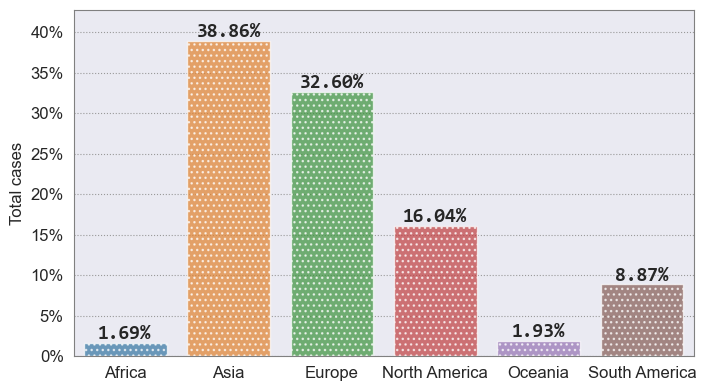

In [44]:
# calcolo della percentuale dei casi per continente
cont_tot_cases = (cont_tot_cases / cont_tot_cases.sum() * 100)
print('\033[01mPercentuale dei casi totali nel mondo divisi per continente:\033[0m', (round(cont_tot_cases, 2).astype(str) + ' %').to_string().replace('continent', ''))

# plot
plt.figure(figsize=(8,4.5))
ax = sns.barplot(cont_tot_cases.to_frame(), x='continent', y='new_cases', hue='continent', hatch='...', alpha=0.7)

# percentuali nel barplot
for cont in ax.containers:
    ax.bar_label(cont, fmt='%.2f%%', weight='bold', fontname='Consolas', size=14)
    
# labels degli assi
ax.set(xlabel='', ylabel='Total cases')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%1.0f%%'))
plt.margins(y=0.1)
plt.show()

## 3. Selezionare i dati relativi all'Italia nel 2022 e mostrare con dei grafici adeguati:

### a. l'evoluzione del casi totali dall'inizio alla fine dell'anno

In [45]:
# check valori nulli sulle date
covid_df.date.isna().value_counts()

date
False    402910
Name: count, dtype: int64

In [46]:
# conversione colonna 'date' in datetime
covid_df.date = pd.to_datetime(covid_df.date)

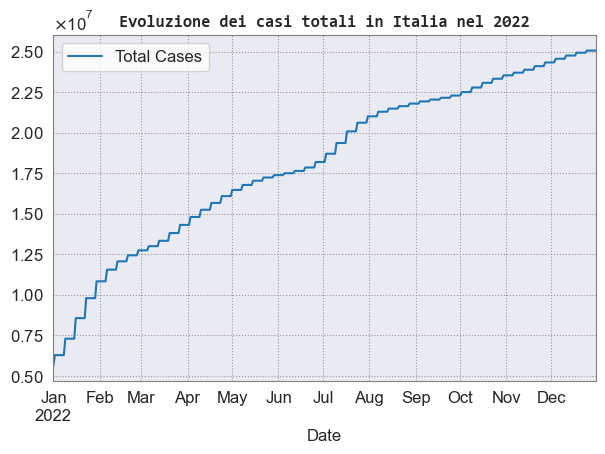

In [47]:
# filtri per data = 2022 e per location = Italy
date_flt = covid_df.date.dt.year == 2022
italy_flt = covid_df.location.str.contains('Italy')

# plot
covid_df[ date_flt & italy_flt ].plot( x = 'date', y = 'total_cases', figsize=(7,4.5))
plt.legend(loc='upper left', labels=['Total Cases'])
plt.title('Evoluzione dei casi totali in Italia nel 2022', fontsize=12, fontweight='bold', fontname='Consolas')
plt.xlabel('Date')
plt.show()

### b. il numero di nuovi casi rispetto alla data; poiché i nuovi casi vengono registrati settimanalmente, filtrare via i dati che non hanno misurazioni

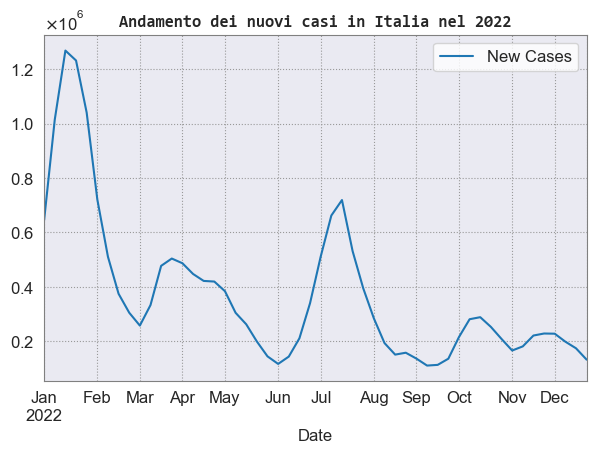

In [48]:
# filtri per i dati uguali a 0
new_cases_flt = covid_df[ date_flt & italy_flt ].new_cases != 0

# plot
covid_df[ date_flt & italy_flt & new_cases_flt ].plot( x = 'date', y = 'new_cases', figsize=(7,4.5))
plt.legend(loc='upper right', labels=['New Cases'])
plt.title('Andamento dei nuovi casi in Italia nel 2022', fontsize=12, fontweight='bold', fontname='Consolas')
plt.xlabel('Date')
plt.show()

## 4. Riguardo le nazioni di Italia, Germania e Francia mostrare in un boxplot la differenza tra queste nazioni riguardo il numero di pazienti in terapia intensiva (Intensive Care Unit, ICU) da maggio 2022 (incluso) ad aprile 2023 (incluso)

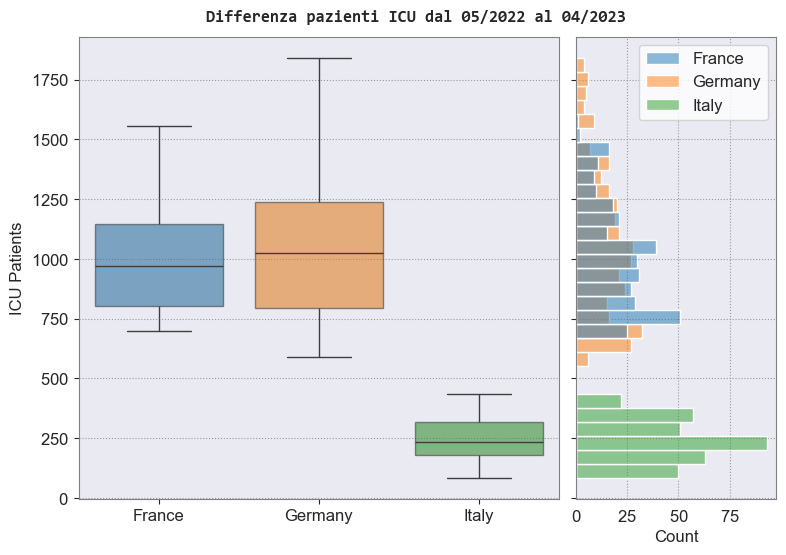

In [49]:
# filtro per le date richieste
start_date_flt = covid_df.date >= pd.to_datetime("2022/05/01")
end_date_flt = covid_df.date <= pd.to_datetime("2023/04/01")
date_flt = start_date_flt & end_date_flt

# filtro per le nazioni richieste
loc_flt = covid_df.location.str.contains('Italy|Germany|France')

# boxplot
fig, ax = plt.subplots(1, 2, figsize=(9,6), width_ratios=[3, 1.25], sharey=True)
plt.subplots_adjust(wspace = 0.05)
fig.suptitle('Differenza pazienti ICU dal 05/2022 al 04/2023', fontsize=12, fontweight='bold', y=0.925, fontname='Consolas')

sns.boxplot(covid_df[ loc_flt & date_flt ], y='icu_patients', x='location', hue='location', ax=ax[0], boxprops=dict(alpha=.6))
ax[0].set(ylabel = 'ICU Patients', xlabel = '')
ax[0].xaxis.tick_bottom()
ax[0].yaxis.tick_left() 

# istogramma
sns.histplot(covid_df[ loc_flt & date_flt ], y='icu_patients', hue='location', bins=30, ax=ax[1]).set(ylabel='')
ax[1].get_legend().set_title('')
ax[1].yaxis.tick_left() 
ax[1].yaxis.set_label_position("right")
plt.show()

### a. scrivere un breve commento a riguardo

<font size="4">**Commento**: la colonna `icu_patients` riporta giornalmente il numero di pazienti in terapia intensiva, dal grafico si può osservare che l'*Italia* presenta un numero di pazienti inferiore rispetto a *Francia* e *Germania*. Tale differenza viene confermata anche dal grafico sottostante, che riporta l'andamento temporale dei pazienti e la somma totale.</font>

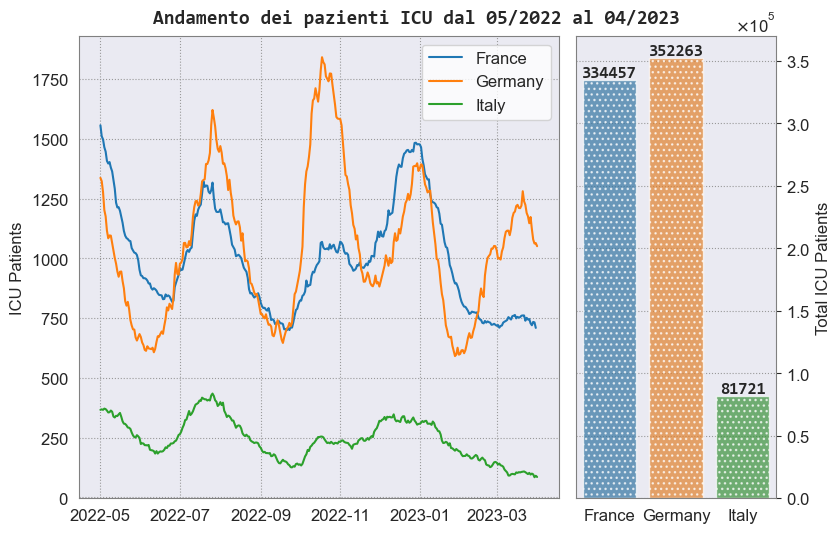

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(9,6), width_ratios=[3, 1.25])
plt.subplots_adjust(wspace = 0.05)
fig.suptitle('Andamento dei pazienti ICU dal 05/2022 al 04/2023', fontsize=14, fontweight='bold', y=0.925, fontname='Consolas')

# plot andamento 'icu_patients' per ogni nazione
sns.lineplot(covid_df[ loc_flt & date_flt ], x='date', y='icu_patients', hue='location', ax=ax[0]).set(xlabel='', ylabel='ICU Patients')
ax[0].legend(title='')

# plot grafico a barre del totale di 'icu_patients' per ogni nazione
sns.barplot(covid_df[ loc_flt & date_flt ], hatch='...', x='location', y='icu_patients',
                 hue='location', estimator='sum', alpha=0.7, errorbar=None, ax=ax[1])
ax[1].set(xlabel='', ylabel='Total ICU Patients')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# scritte del totale sulle barre
for cont in ax[1].containers:
    ax[1].bar_label(cont, fmt='%d', weight='bold', fontname='Consolas', size=12) 
plt.show()

## 5. Riguardo le nazioni di Italia, Germania, Francia e Spagna in tutto il 2023:

### a. mostrare la somma dei pazienti ospitalizzati per ognuna

Pazienti ospedalizzati:
France     1382574
Germany          0
Italy      1175272
Spain       354602


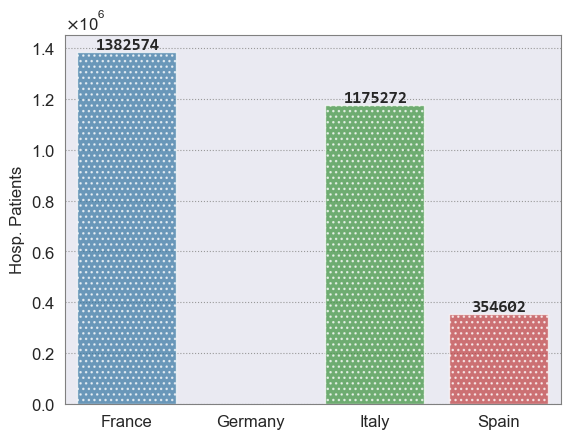

In [51]:
# filtri data e nazioni
date_flt = covid_df.date.dt.year == 2023
loc_flt = covid_df.location.str.contains('Italy|Germany|France|Spain')

# stampa dei dati
print('\033[01mPazienti ospedalizzati:\033[0m')
print(covid_df[ loc_flt & date_flt ].groupby('location').hosp_patients.sum().astype(int).to_string().replace('location\n',''))

ax = sns.barplot(covid_df[ loc_flt & date_flt ], hatch='...', x='location', y='hosp_patients',
                 hue='location', estimator='sum', alpha=0.7, errorbar=None)

# scritte del totale sulle barre
for cont in ax.containers:
    ax.bar_label(cont, fmt='%d', weight='bold', fontname='Consolas', size=12) 
ax.set(xlabel='', ylabel='Hosp. Patients')    
plt.show()

### b. se ci sono dati nulli, con un breve commento scrivere se può essere possibile gestirli tramite sostituzione o meno

<font size="4">**Commento**: la colonna `hosp_patients` riporta giornalmente il numero di pazienti ospedalizzati. Per la *Germania* sono riportate le ammissioni ospedaliere settimanali (colonna `weekly_hosp_admissions`) e non i pazienti giornalieri, quindi non è possibile sostiuire i dati mancanti.</font>

Ammissioni ospedaliere settimanali:
France     268117
Germany    897776
Italy      592019
Spain      299463


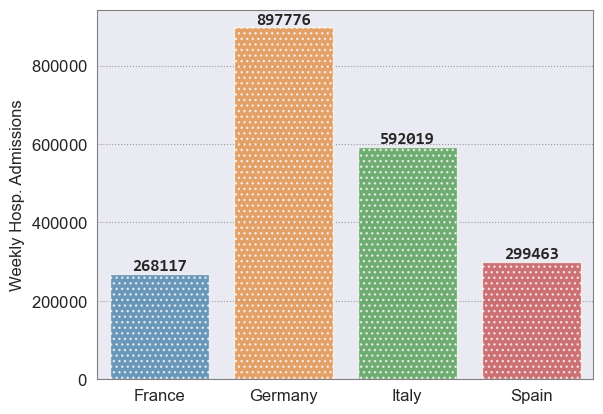

In [52]:
print('\033[01mAmmissioni ospedaliere settimanali:\033[0m')
print(covid_df[ loc_flt & date_flt ].groupby('location').weekly_hosp_admissions.sum().astype(int).to_string().replace('location\n',''))

ax = sns.barplot(covid_df[ loc_flt & date_flt ], hatch='...', x='location', y='weekly_hosp_admissions',
                 hue='location', estimator='sum', alpha=0.7, errorbar=None)

# scritte del totale sulle barre
for cont in ax.containers:
    ax.bar_label(cont, fmt='%d', weight='bold', fontname='Consolas', size=12) 
ax.set(xlabel='', ylabel='Weekly Hosp. Admissions')    
plt.show()